In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

import json
from itertools import chain
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score,classification_report

# import sys  
# stdin, stdout, stderr = sys.stdin, sys.stdout, sys.stderr

# sys.setdefaultencoding('utf8')
# sys.stdin, sys.stdout, sys.stderr = stdin, stdout, stderr

# Any results you write to the current directory are saved as output.

In [2]:
with open("../input/train.json",encoding='utf-8') as file:
    train = json.load(file)
with open("../input/test.json",encoding='utf-8') as file:
    test = json.load(file)

train = pd.DataFrame(train)
test = pd.DataFrame(test)
sample_submission = pd.read_csv("../input/sample_submission.csv")

In [3]:
print(train.shape)
print(test.shape)

(39774, 3)
(9944, 2)


In [4]:
print(train.head(3))
print("==================")
print(test.head(3))

       cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
      id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...


In [5]:
print(train.columns)
print("==============")
print(test.columns)
print("==============")
print(sample_submission.columns)

Index(['cuisine', 'id', 'ingredients'], dtype='object')
Index(['id', 'ingredients'], dtype='object')
Index(['id', 'cuisine'], dtype='object')


In [6]:
print(train['cuisine'].value_counts(normalize=True))

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64


In [7]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
## Different ingredients
total_cuisine = train.cuisine.nunique()
print(train.cuisine.nunique())
print(len(list(set(chain(*train['ingredients'].tolist())))))
print(list(set(chain(*train['ingredients'].tolist()))))

20
6714
['shredded coleslaw mix', 'Knudsen Light Sour Cream', 'red bean paste', 'reduced fat cream of mushroom soup', 'La Victoria Red Chile Sauce', 'soft-wheat flour', 'wonton noodles', 'mushroom soup', 'puffed rice', 'pork shoulder butt', 'black chicken', 'tortilla chips', 'abalone', 'frozen limeade concentrate', 'dipping chocolate', 'ground thyme', 'chicken consomme', 'vegetable stock', 'low-fat crème fraîche', 'smoked mackerel', 'wheels', 'ground lamb', 'chocolate chip cookie dough ice cream', 'roasted peanuts', 'mascarpone', 'collards', 'natural peanut butter', 'yellow lentils', 'pork shoulder roast', 'canning salt', 'coffee beans', 'cut up chicken', 'raw peeled prawns', 'Ortega Tostada Shells', 'chicken bouillon granules', 'turkey gravy', 'veal shoulder', 'crusty sandwich rolls', 'spring roll wrappers', 'Japanese turnips', 'biscuit dough', 'large snails', 'hillshire farms low fat sausage', 'reduced fat swiss cheese', 'cured chorizo', 'v 8 juice', 'besan (flour)', 'jack', 'pangasi

###########
## THOUGHTS
###########
1) If ingredient is present across all cuisine types, no need of that ingredient
2) 

In [9]:
def get_ingredients_list(x):
    list_values_list = list(x)
    flattened_values = list(chain.from_iterable(list_values_list))
    return list(set(flattened_values))

cuisine_ingredient = train.groupby('cuisine').aggregate({'ingredients':get_ingredients_list})
cuisine_ingredient_wise = list(cuisine_ingredient['ingredients'])
ingredient_list = list(set(chain(*train['ingredients'].tolist())))

def presence_count_across_cuisine(ingredient,cuisine_ingredient_wise):
    count=0
    for i in cuisine_ingredient_wise:
        if ingredient in i:
            count+=1
    return count

ingredient_cuisine_count = dict()
for ingredient in ingredient_list:
    ingredient_cuisine_count[ingredient] = presence_count_across_cuisine(ingredient,cuisine_ingredient_wise)


In [ ]:
# type(cuisine_ingredient)
# cuisine_ingredient.head()
# cuisine_ingredient.columns
# cuisine_ingredient.index


In [10]:
ingredient_cuisine_count

{'spicy pork sausage': 6,
 'low-fat vanilla ice cream': 1,
 'quinoa': 16,
 'fat free less sodium beef broth': 8,
 'graham crackers': 6,
 'organic milk': 2,
 'Knudsen Light Sour Cream': 1,
 'red bean paste': 2,
 'reduced fat cream of mushroom soup': 1,
 'beni shoga': 2,
 'reduced sodium chicken flavor stuffing mix': 1,
 'truffle butter': 1,
 'herbsaint': 1,
 'red mustard': 1,
 'La Victoria Red Chile Sauce': 1,
 'king oyster mushroom': 1,
 'Vegeta Seasoning': 1,
 'soft-wheat flour': 2,
 'guacamole': 4,
 'Melba toast': 2,
 'Irish whiskey': 2,
 'wonton noodles': 1,
 'Mexican oregano': 3,
 'chocolatecovered espresso beans': 1,
 'mushroom soup': 4,
 'puffed rice': 1,
 'ranch salad dressing mix': 1,
 'pork shoulder butt': 6,
 'celery powder': 1,
 'chinese pepper': 1,
 'chocolate spread': 2,
 'vinaigrette': 12,
 'frozen whip topping, thaw': 3,
 'black chicken': 1,
 'tortilla chips': 6,
 'abalone': 1,
 'frozen limeade concentrate': 4,
 'sour cherries': 9,
 'dipping chocolate': 1,
 'unsweetened 

In [11]:
# no of ingredients present acorss all cuisine type
ingredient_omni = list()
ingredient_omni_count=0
ingredient_single = list()
ingredient_single_count = 0
for ingredient in ingredient_cuisine_count:
    if ingredient_cuisine_count[ingredient] == total_cuisine:
        ingredient_omni.append(ingredient)
        ingredient_omni_count+=1
    elif ingredient_cuisine_count[ingredient] == 1:
        ingredient_single.append(ingredient)
        ingredient_single_count+=1

In [12]:
print("Ingredient present across all cuisine types - {}".format(ingredient_omni_count))
print("Ingredient present in only one cuisine - {} ".format(ingredient_single_count))
print(ingredient_omni)
print(ingredient_single)

Ingredient present across all cuisine types - 107
Ingredient present in only one cuisine - 2597 
['vegetable stock', 'water', 'ketchup', 'peas', 'white vinegar', 'tomatoes', 'white sugar', 'cracked black pepper', 'mayonaise', 'shallots', 'seasoning', 'warm water', 'black pepper', 'dry white wine', 'yellow onion', 'white wine vinegar', 'butter', 'brown sugar', 'purple onion', 'bread', 'minced garlic', 'vegetable broth', 'cinnamon sticks', 'red bell pepper', 'whole milk', 'chicken stock', 'bay leaf', 'green bell pepper', 'sweet potatoes', 'celery', 'tomato paste', 'jalapeno chilies', 'red wine vinegar', 'garlic cloves', 'dijon mustard', 'ground black pepper', 'beef', 'hot water', 'garlic powder', 'garlic', 'sugar', 'paprika', 'coarse salt', 'freshly ground pepper', 'beef broth', 'zucchini', 'soy sauce', 'canola oil', 'chicken broth', 'orange juice', 'unsalted butter', 'potatoes', 'white onion', 'salt', 'lemon', 'celery ribs', 'bay leaves', 'baking powder', 'plum tomatoes', 'sauce', 'fres

In [13]:
def sub_space(x):
    temp_value = list()
    for i in x:
        temp_value.append(re.sub(r'[^0-9a-zA-Z]+','_',i))
    return temp_value

train['ingredients_new'] = train['ingredients'].apply(sub_space)
test['ingredients_new'] = test['ingredients'].apply(sub_space)

In [14]:
train.head()

,cuisine,id,ingredients,ingredients_new
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","[plain_flour, ground_pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking_oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","[water, vegetable_oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


In [15]:
def convert_list_to_sent(x):
    return ' '.join(x)

train['ingredient_sent'] = train['ingredients_new'].apply(convert_list_to_sent)
test['ingredient_sent'] = test['ingredients_new'].apply(convert_list_to_sent)

In [16]:
train.head()

,cuisine,id,ingredients,ingredients_new,ingredient_sent
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes...",romaine_lettuce black_olives grape_tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","[plain_flour, ground_pepper, salt, tomatoes, g...",plain_flour ground_pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking_oil, g...",eggs pepper salt mayonaise cooking_oil green_c...
3,indian,22213,"[water, vegetable oil, wheat, salt]","[water, vegetable_oil, wheat, salt]",water vegetable_oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","[black_pepper, shallots, cornflour, cayenne_pe...",black_pepper shallots cornflour cayenne_pepper...


In [17]:
X_train, X_test, y_train, y_test = train_test_split(train['ingredient_sent'], train['cuisine'], test_size=0.33, random_state=42)

In [18]:
vectorizer = CountVectorizer(lowercase=True,binary=True)
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [19]:
pd.DataFrame(X_train_count.todense(), columns=vectorizer.get_feature_names()).head()

,1_low_fat_buttermilk,1_low_fat_chocolate_milk,1_low_fat_cottage_cheese,1_low_fat_milk,25_less_sodium_chicken_broth,2_1_2_to_3_lb_chicken_cut_into_serving_pieces,2_low_fat_cheddar_chees,2_low_fat_cottage_cheese,2_lowfat_greek_yogurt,2_milk_shredded_mozzarella_cheese,...,yuzu_juice,yuzukosho,za_atar,zatarain_s_jambalaya_mix,zest,zesty_italian_dressing,zinfandel,ziti,zucchini,zucchini_blossoms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print(X_train_count.shape)
print(X_test_count.shape)


(26648, 5988)
(13126, 5988)


## Max_depth Analaysis

In [21]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    print(max_depth)
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train_count,y_train)
    y_pred_test = model.predict(X_test_count)
    y_pred_train = model.predict(X_train_count)
    train_results.append(accuracy_score(y_train,y_pred_train))
    test_results.append(accuracy_score(y_test,y_pred_test))    

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


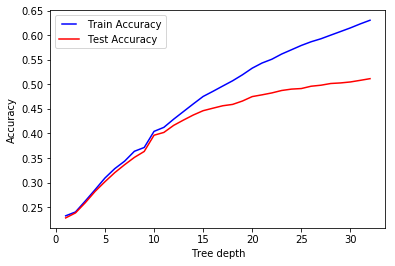

In [22]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline
line1, = plt.plot(max_depths, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel("Accuracy")
plt.xlabel("Tree depth")
plt.show()

## Min samples split

In [23]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    print(min_samples_split)
    model = DecisionTreeClassifier(min_samples_split=min_samples_split)
    model.fit(X_train_count,y_train)
    y_pred_test = model.predict(X_test_count)
    y_pred_train = model.predict(X_train_count)
    train_results.append(accuracy_score(y_train,y_pred_train))
    test_results.append(accuracy_score(y_test,y_pred_test))   

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


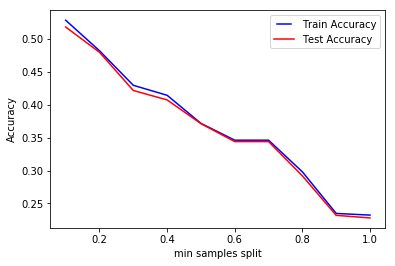

In [24]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel("Accuracy")
plt.xlabel("min samples split")
plt.show()

## Min sample leaf

In [25]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    print(min_samples_leaf)
    model = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train_count,y_train)
    y_pred_test = model.predict(X_test_count)
    y_pred_train = model.predict(X_train_count)
    train_results.append(accuracy_score(y_train,y_pred_train))
    test_results.append(accuracy_score(y_test,y_pred_test))   

0.1
0.2
0.30000000000000004
0.4
0.5


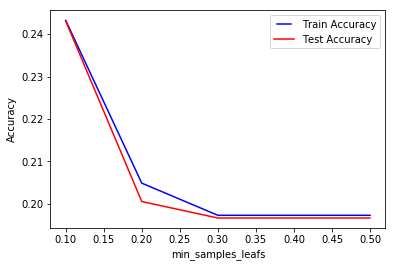

In [26]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel("Accuracy")
plt.xlabel("min_samples_leafs")
plt.show()

In [27]:
max_features = list(range(1,train.shape[1]))


In [51]:
# model = DecisionTreeClassifier(max_depth=10) -- 40,39
# model = DecisionTreeClassifier(min_samples_leaf=30)
model = DecisionTreeClassifier(min_samples_split=0.12)

model.fit(X_train_count,y_train)
y_pred_test = model.predict(X_test_count)
y_pred_train = model.predict(X_train_count)

In [52]:
y_pred_test

array(['chinese', 'italian', 'italian', ..., 'southern_us', 'indian',
       'italian'], dtype=object)

In [53]:
print("Accuracy on train set is {}".format(accuracy_score(y_train,y_pred_train)))
print("Accuracy on test set is {}".format(accuracy_score(y_test,y_pred_test)))

Accuracy on train set is 0.518087661362954
Accuracy on test set is 0.512799024836203


In [31]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

   brazilian       1.00      0.16      0.28       164
     british       0.19      0.05      0.08       271
cajun_creole       0.49      0.45      0.47       530
     chinese       0.53      0.71      0.61       835
    filipino       0.32      0.29      0.30       225
      french       0.35      0.31      0.33       911
       greek       0.67      0.37      0.47       382
      indian       0.70      0.67      0.68       992
       irish       0.27      0.08      0.12       222
     italian       0.56      0.80      0.66      2581
    jamaican       0.21      0.11      0.14       150
    japanese       0.55      0.42      0.48       488
      korean       0.61      0.30      0.40       275
     mexican       0.72      0.77      0.74      2138
    moroccan       0.44      0.28      0.34       261
     russian       0.29      0.05      0.08       155
 southern_us       0.43      0.54      0.47      1426
     spanish       0.34    

[[  27    0    4    4    1    6    0    3    2   32    1    0    0   38
     4    1   26    1   11    3]
 [   0   13    7    4    4   38    0    6    6   61    1    0    0   13
     0    3  114    0    0    1]
 [   0    4  237   11    6   21    1   12    1   89    4    3    0   47
     5    2   80    5    1    1]
 [   0    0   14  593   22   15    2    6    0   45    2   50   28   17
     0    0   24    0   10    7]
 [   0    2    3   43   65    7    0    3    1   21    8    2    1   10
     0    0   30    0   22    7]
 [   0    7   21   16    2  285    2   13   10  353    2    2    0   19
     0    2  159   18    0    0]
 [   0    0    5    4    0   24  140    6    0  145    0    2    0   20
     6    0   20   10    0    0]
 [   0    6   11   13   13   16    4  661    1   59   13    5    1  105
    28    0   41    5   10    0]
 [   0    5    6    0    7   21    1    2   17   52    0    1    0   12
     0    0   93    2    0    3]
 [   0    9   29   24    4  150   33   14    5 2054    

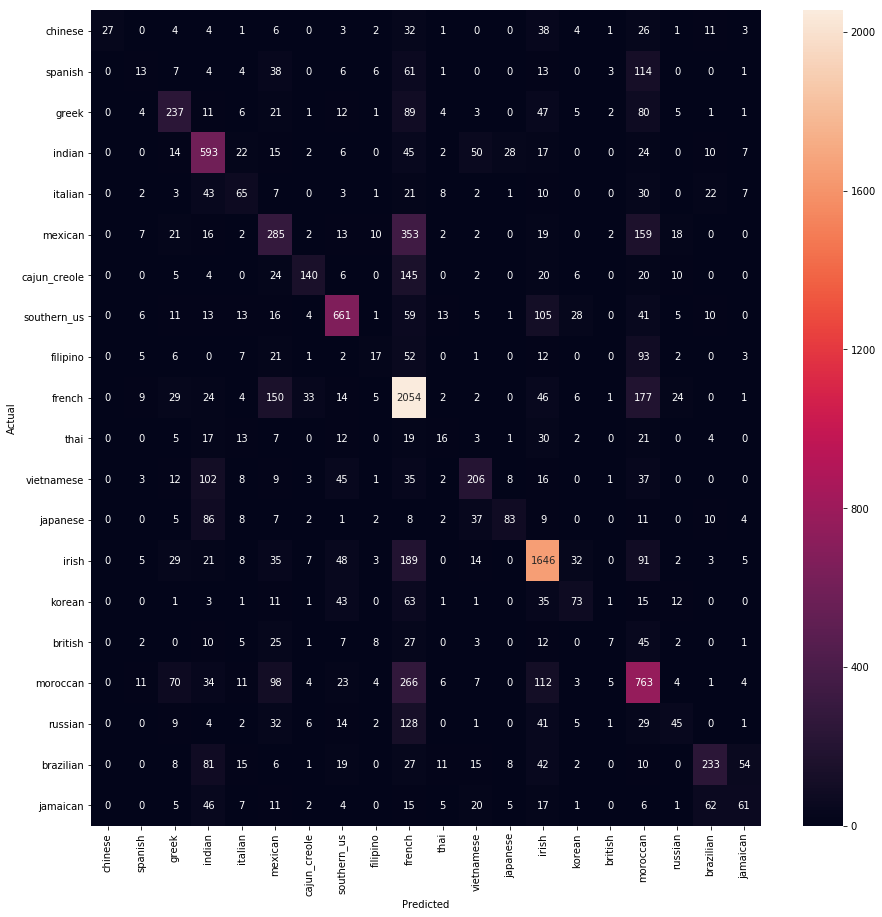

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(15,15))
print(conf_mat)

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
from collections import Counter
Counter(list(y_pred_test))

Counter({'brazilian': 27,
         'british': 67,
         'cajun_creole': 481,
         'chinese': 1116,
         'filipino': 202,
         'french': 824,
         'greek': 210,
         'indian': 942,
         'irish': 63,
         'italian': 3688,
         'jamaican': 76,
         'japanese': 374,
         'korean': 135,
         'mexican': 2287,
         'moroccan': 167,
         'russian': 24,
         'southern_us': 1792,
         'spanish': 131,
         'thai': 367,
         'vietnamese': 153})

## Experimental results
1) max_depth = 10 --  40,39
2) min_samples_leaf=10 -- 64,57
3) min_samples_leaf=15 -- 62,57
4) min_samples_leaf=15,min_samples_split=10 -- 62,57
5) min_samples_split=10 -- 88,59
6) min_samples_leaf=30 -- 57,55


In [36]:
## Final Model on 100% dataset


In [59]:
vectorizer = CountVectorizer(lowercase=True,binary=True)
X_train_all_count = vectorizer.fit_transform(train['ingredient_sent'])
X_test_all_count = vectorizer.transform(test['ingredient_sent'])
y_train_all = train['cuisine']

In [60]:
print(X_train_all_count.shape)
print(X_test_all_count.shape)

(39774, 6695)
(9944, 6695)


In [61]:
model = DecisionTreeClassifier(min_samples_leaf=30)
model.fit(X_train_all_count,y_train_all)
y_pred_test = model.predict(X_test_all_count)

In [62]:
test.head()

,id,ingredients,ingredients_new,ingredient_sent
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","[baking_powder, eggs, all_purpose_flour, raisi...",baking_powder eggs all_purpose_flour raisins m...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","[sugar, egg_yolks, corn_starch, cream_of_tarta...",sugar egg_yolks corn_starch cream_of_tartar ba...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","[sausage_links, fennel_bulb, fronds, olive_oil...",sausage_links fennel_bulb fronds olive_oil cub...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","[meat_cuts, file_powder, smoked_sausage, okra,...",meat_cuts file_powder smoked_sausage okra shri...
4,35687,"[ground black pepper, salt, sausage casings, l...","[ground_black_pepper, salt, sausage_casings, l...",ground_black_pepper salt sausage_casings leeks...


In [56]:
sample_submission.head()

,id,cuisine
0,35203,italian
1,17600,italian
2,35200,italian
3,17602,italian
4,17605,italian


In [64]:
result = test[['id']]
result['cuisine'] = y_pred_test

len(y_pred_test)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9944

In [65]:
result.head()

,id,cuisine
0,18009,mexican
1,28583,french
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [66]:
result.to_csv('../output/result_v1.csv',index=False)

### References
1) https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
2) https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
3) 